In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from Modules.EuclideanM import *
from Modules.EuclideanV import *
from Modules.EuclideanC import *

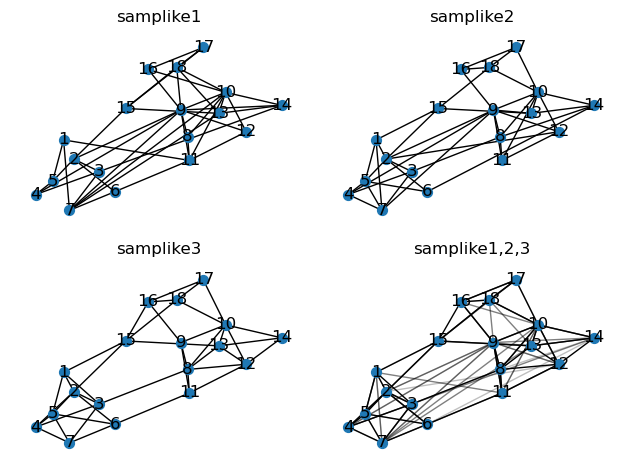

In [4]:
import zipfile
from io import BytesIO as StringIO

import matplotlib.pyplot as plt
import networkx as nx

with zipfile.ZipFile("sampson_data.zip") as zf:
    e1 = StringIO(zf.read("samplike1.txt"))
    e2 = StringIO(zf.read("samplike2.txt"))
    e3 = StringIO(zf.read("samplike3.txt"))

G = nx.read_edgelist(e1, delimiter="\t")
G2 = nx.read_edgelist(e2, delimiter="\t")
G3 = nx.read_edgelist(e3, delimiter="\t")
pos = nx.spring_layout(G3, iterations=100, seed=173)
plt.clf()

plt.subplot(221)
plt.title("samplike1")
nx.draw(G, pos, node_size=50, with_labels=True)
plt.subplot(222)
plt.title("samplike2")
nx.draw(G2, pos, node_size=50, with_labels=True)
plt.subplot(223)
plt.title("samplike3")
nx.draw(G3, pos, node_size=50, with_labels=True)
plt.subplot(224)
plt.title("samplike1,2,3")
nx.draw(G3, pos, edgelist=list(G3.edges()), node_size=50, with_labels=True)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_edges(G2, pos, alpha=0.25)
plt.tight_layout()
plt.show()

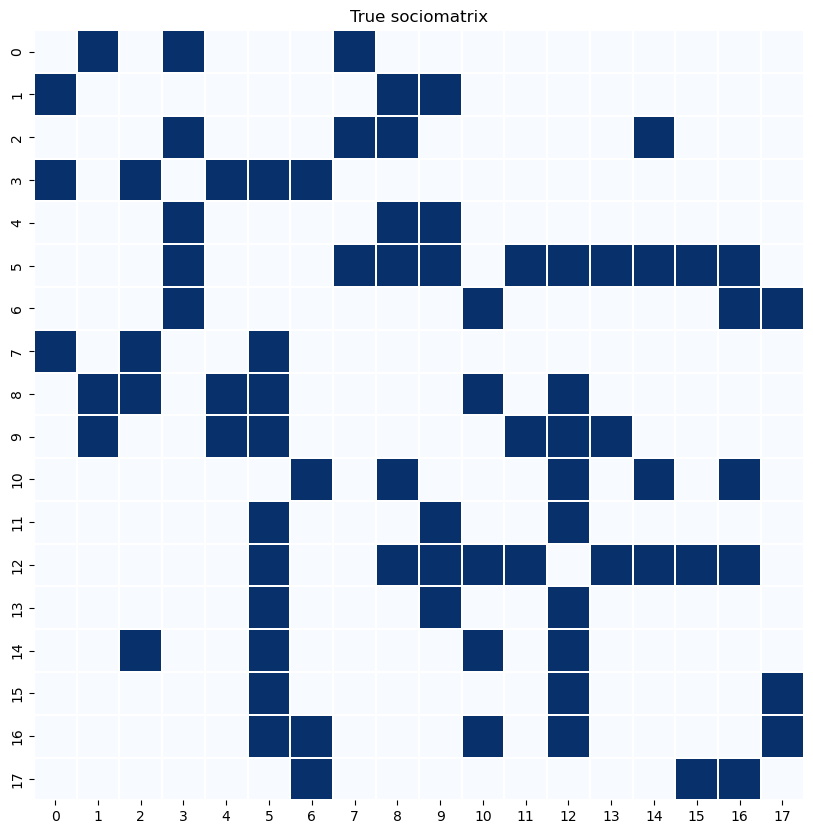

In [9]:
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)


Y = nx.to_numpy_array(G, dtype=float)

plt.figure(figsize=(10, 10))
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.01, linecolor='white')
plt.title("True sociomatrix")
plt.show()

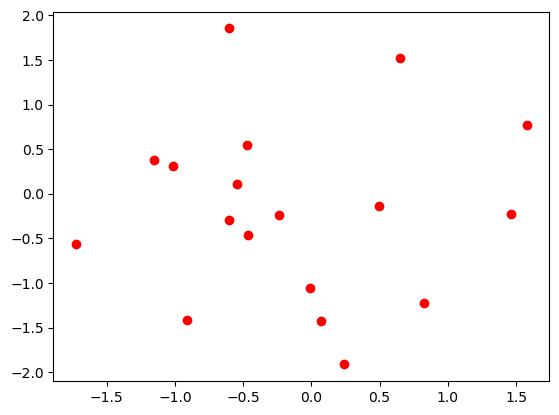

In [7]:
n = len(G.nodes)

Z = np.random.randn(n, 2)
plt.plot(Z[:,0],Z[:,1], 'ro')
plt.show()

Loglikelihood: -94.87925181894357


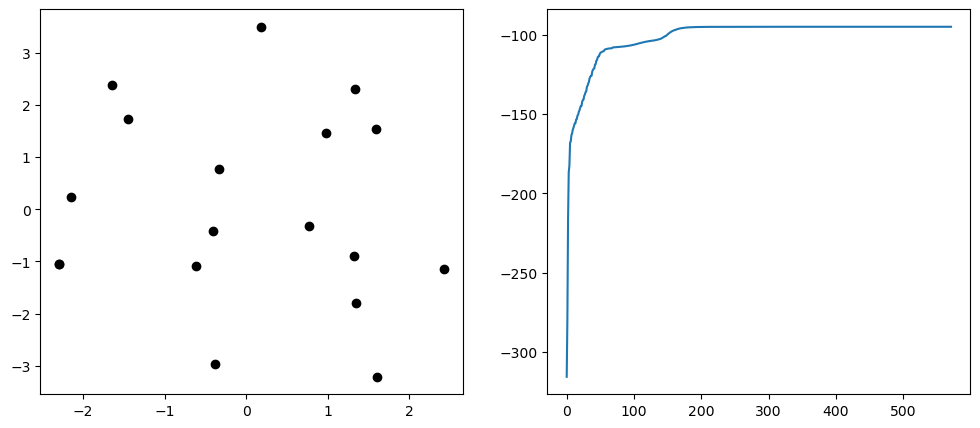

In [11]:
Z_ML, a_ML, historyZ, historya  =  SearchingMLE(G, np.random.randn(n, 2),np.random.randn(),1000)
Z_ML = Z_ML - np.mean(Z_ML, axis=0)

print("Loglikelihood:", loglikelihood(G, Z_ML,a_ML))

fig, ax = plt.subplots(1,2,figsize = (12,5))
ax[0].plot(Z_ML[:,0],Z_ML[:,1], 'ko')
ax[1].plot([loglikelihood(G, historyZ[t],historya[t]) for t in range(len(historya))])
plt.show()

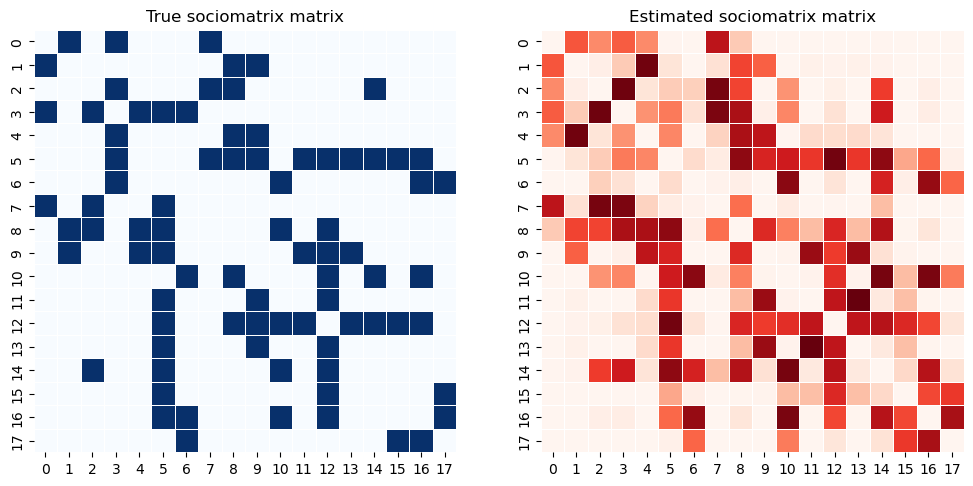

In [12]:
Y_ML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y_ML[i,j] = expit(a_ML - 0.5 * np.linalg.norm(Z_ML[i] - Z_ML[j])**2)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

In [ ]:
# Execute HMC
number_of_samples = 250
Z_init = np.random.randn(Z_ML.shape[0],Z_ML.shape[1])
a_init = np.random.randn(1)

print("Log-L MLE:", loglikelihood(G,Z_ML,a_ML))
print("Log-L starter:", loglikelihood(G,Z_init,a_init)[0])

samples_Z, samples_a, Hp, LogLp, acep_rate_history = hmc(G, Z_init, a_init, number_of_samples, 
                                                         epsilon_init=0.15, std_dev=1.0, percentage_warmup=0.2, Z0 = Z_ML)

# Estimators
## CM
Z_CM =  np.mean(samples_Z, axis=0)
a_CM = np.mean(samples_a, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]


print("Log-L MAP:", loglikelihood(G,Z_MAP,a_MAP))
print("Log-L CM:", loglikelihood(G,Z_CM,a_CM))

Log-L MLE: -94.87925181894357
Log-L starter: -227.3427596851104
Number of samples: 250
Number of parameters: 19
Number of iterations: 300
Number of warmup iterations: 50


 17%|█▋        | 50/300 [00:32<02:32,  1.64it/s]

Final parameters: epsilon=0.0935, L=11, std_dev=0.6235


100%|██████████| 300/300 [03:04<00:00,  1.63it/s]

Acceptance rate: 0.49719
Log-L MAP: -100.84868016478751
Log-L CM: -99.59504734435916


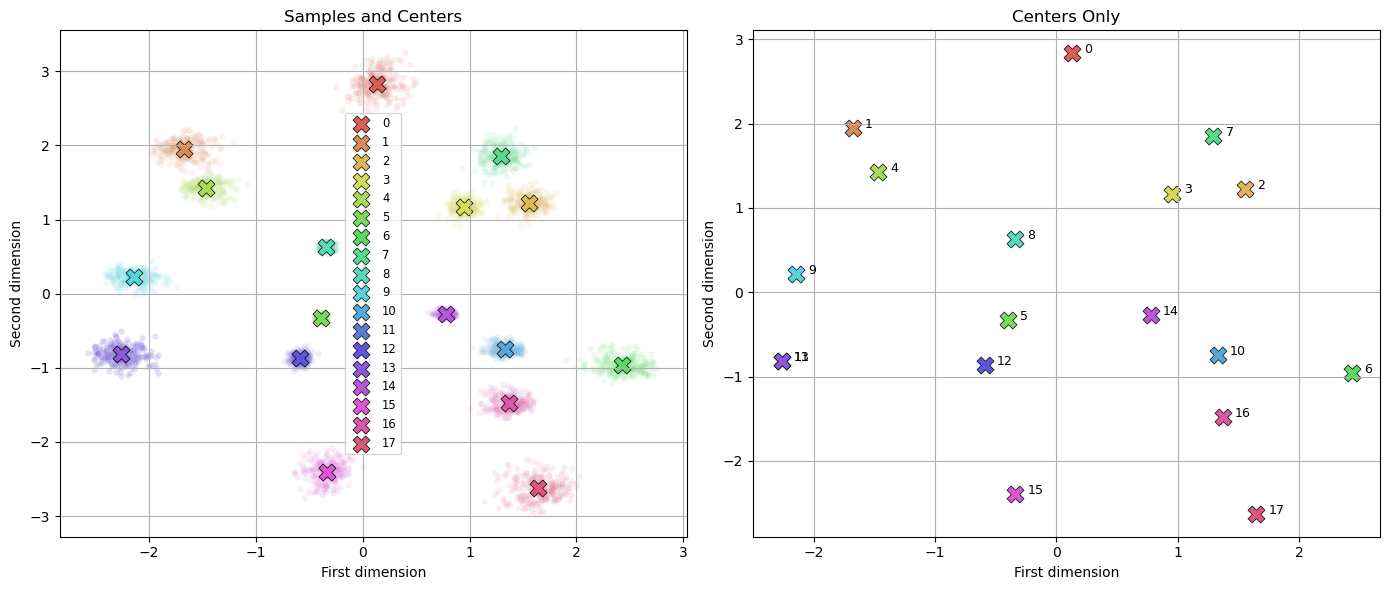

In [14]:
plot_Z_samples_2D(samples_Z)

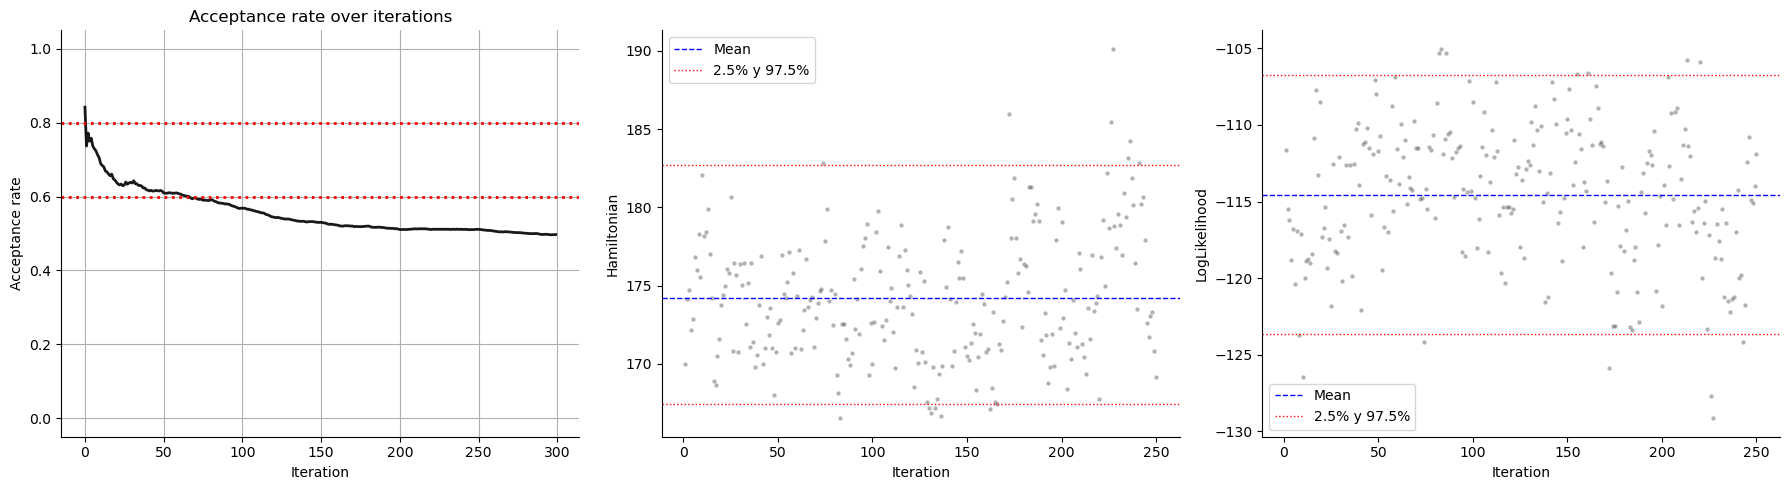

In [15]:
plot_diagnostics(Hp,LogLp,acep_rate_history)

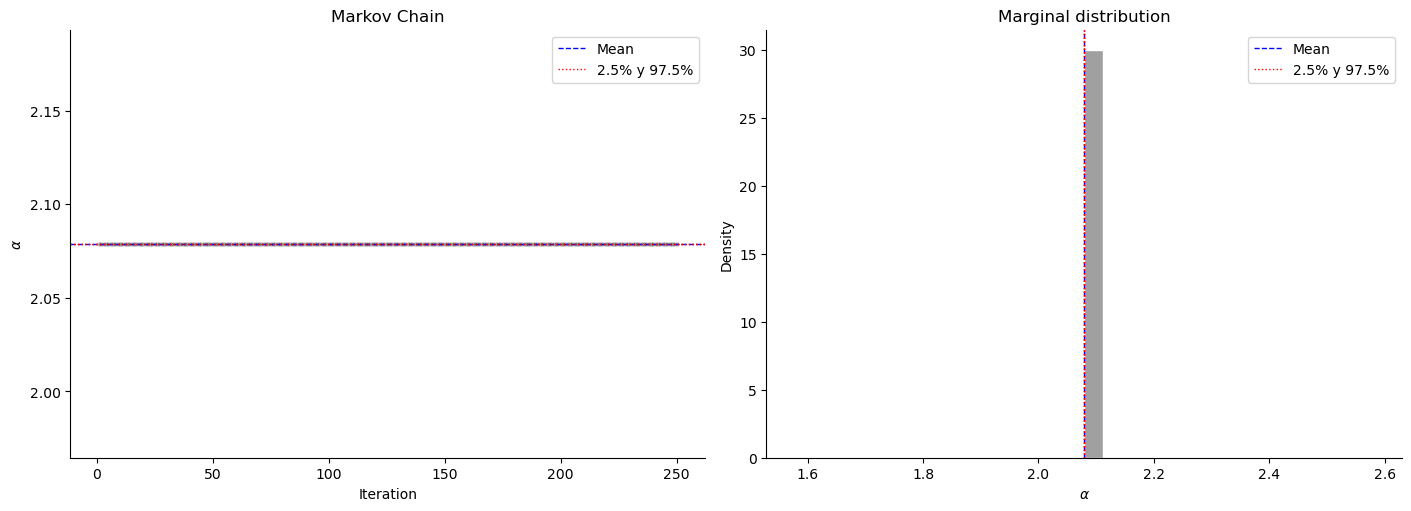

In [16]:
plot_alpha(samples_a)